In [1]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functions import *
import cobra
from cobra.io import read_sbml_model,load_json_model
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats

In [2]:
model = load_json_model('../data/GSMM_parameters/LP_WCFS1.json')
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
gene_info = proB[list(proB.columns[0:5])]
proB = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
uniprot_info = pd.read_csv('../data/Proteomics/uniprotkb_taxonomy_id_220668.tsv',sep='\t')

In [3]:
deg_5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5vs6d5_B.csv")
deg_4d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_4d5vs6d5_B.csv")

# Map expression to reactions
* Central carbon metabolism
* Purine and pyrimidine

In [4]:
cc_rxns = ['GLCpts','PGMT','GALU','UDPG4E','MAN6PI','PMANM',
       'PGI','PFK','FBA','TPI','GAPD','PGK','PGM','ENO','PYK',
       'PDH','PTAr','ACKr','PFL','LDH_D','LDH_L','ACCOAC','MACPMT','kaasIII',
       'G6PDH2r','PGL','GND','RPE','RPI','TKT1','TKT2','TALA']

pyr_rxns = ['ASPCT','DHORTS','DHORD6','ORPT','OMPDC','PRPPS',
           'GLUPRT','PRAGS','GARFT','PRFGS','PRAIS','AIRC','PRASCS','ADSL2',
           'AICART','IMPC','IMPD','GMPS2']

In [5]:
def locus2id(locus, uniprot_info):
    temp = uniprot_info[uniprot_info['Gene Names (ordered locus)']==locus] 
    return list(temp['Entry'])[0]
    
    
def get_expr(gene, table, cond):
    if gene not in list(table['Accession']):
        return 0
    temp_pd = (table[table['Accession']==gene]).reset_index().drop(['index'],axis=1)
    expr = sum( [temp_pd[cond+'-B'+str(i)][0] for i in range(1,4) ] )/3
    return expr

def expr_or( gene_list, uniprot_info, expr_table, cond ):
    gids = [ locus2id(x.strip(), uniprot_info) for x in gene_list]
    expr = sum([get_expr(gid, expr_table, cond) for gid in gids])
    return expr

def expr_and( gene_list, uniprot_info, expr_table, cond ):
    gids = [ locus2id(x.strip(), uniprot_info) for x in gene_list]
    expr = min([get_expr(gid, expr_table, cond) for gid in gids])
    return expr

def get_rxn_expr( gpr, uniprot_info, expr_table, cond):
    if '(' not in gpr:
        if 'or' in gpr:
            expr = expr_or( gpr.split('or'), uniprot_info, expr_table, cond )
        else:
            expr = expr_and( gpr.split('and'), uniprot_info, expr_table, cond )
    elif ('(' in gpr) and ('and' in gpr) and ('or' in gpr): # for GLCpts/AIRC special case
        gpr_list = gpr.split('or')
        expr_1 = expr_and( gpr_list[0].replace('(','').replace(')','').split('and'), uniprot_info, expr_table, cond )
        expr_2 = expr_and( gpr_list[1].replace('(','').replace(')','').split('and'), uniprot_info, expr_table, cond )
        expr = expr_1 + expr_2
    elif ('(' in gpr) and ('and' in gpr):
        gpr = gpr.replace('(','').replace(')','')
        expr = expr_and( gpr.split('and'), uniprot_info, expr_table, cond )
        
    return expr  

In [6]:
data = []
for rxn_id in cc_rxns:
    temp = {'RXN':rxn_id}
    gpr = model.reactions.get_by_id( rxn_id ).gene_reaction_rule
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = get_rxn_expr( gpr, uniprot_info, proB, cond)
        temp[cond] = expr
    data.append(temp)
    
cc_rxn_expr = pd.DataFrame(data)
idx_keep = cc_rxn_expr.index[ cc_rxn_expr[cc_rxn_expr.columns[1:5]].sum(axis=1)>0 ]
cc_rxn_expr = (cc_rxn_expr.iloc[idx_keep]).reset_index().drop(['index'],axis=1)

for acid_cond in ['pH5.5','pH5','pH4.5']:
    cc_rxn_expr[ 'Log2FC_'+ acid_cond + 'vsRef' ] = list( np.log2( cc_rxn_expr[acid_cond]/cc_rxn_expr['pH6.5'] ) )
# cc_rxn_expr.to_csv('../data/Proteomics/cc_RXN_lfc.csv',index=None)

In [7]:
data = []
for rxn_id in pyr_rxns:
    temp = {'RXN':rxn_id}
    gpr = model.reactions.get_by_id( rxn_id ).gene_reaction_rule
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = get_rxn_expr( gpr, uniprot_info, proB, cond)
        temp[cond] = expr
    data.append(temp)
pyr_rxn_expr = pd.DataFrame(data)
for acid_cond in ['pH5.5','pH5','pH4.5']:
    pyr_rxn_expr[ 'Log2FC_'+ acid_cond + 'vsRef' ] = list( np.log2( pyr_rxn_expr[acid_cond]/pyr_rxn_expr['pH6.5'] ) )
# pyr_rxn_expr.to_csv('../data/Proteomics/pyr_RXN_lfc.csv' ,index=None)

# Resource allocation between proteome sectors

In [8]:
sectors = {'C':[],'T':[],'A':[],'U':[]}
sectors['T'] = ['F9UST3', 'F9UR54','F9UN59','F9UN60'] # lactic acid transporter, GLCpts, 

In [9]:
#A sector includes ribosomal proteins, chaperones, DNA/RNA polymerases
for i in range(len(gene_info.index) ):
    g_name = list(gene_info['Protein Name'])[i]
    if 'ribosomal subunit protein' in g_name or 'ribosomal protein' in g_name :
        sectors['A'].append( list(gene_info['Accession'])[i].strip() )
    elif ('Chaperone' in g_name) or ('Chaperonin' in g_name) or ('chaperone' in g_name) or ('chaperonin' in g_name):
        sectors['A'].append( list(gene_info['Accession'])[i].strip() )

In [10]:
cc_proteins = []
for rxn_id in cc_rxns:
    genes = model.reactions.get_by_id( rxn_id ).genes
    for g in genes:
        cc_proteins.append( locus2id( g.id, uniprot_info) )
cc_proteins = list(set(cc_proteins).intersection(set(list(gene_info['Accession']))))
sectors['C'] = cc_proteins

In [11]:
column_names = ('query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score').split(', ')
data = []
ffile = open('../data/Genome_HMX2/eps_blast_uniprot.tsv', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    line = line.strip()
    if '#' not in line:
        data.append( line.split('\t'))
blast_result = pd.DataFrame(data ,columns=column_names)
blast_result = blast_result[blast_result['query acc.ver']!='1_990'] #remove AraC
EPS_genes = list( set(blast_result['subject acc.ver']).intersection(set(list(gene_info['Accession']))) )
EPS_genes = list( set(EPS_genes)-set(cc_proteins) )
sectors['U'] = EPS_genes

In [12]:
sector_expr = []
for sec in ['C','T','A','U']:
    data = {'sector':sec}
    temp = proB[proB.Accession.isin(sectors[sec])][proB.columns[1:]]
    temp_dict = dict(temp.sum())
    data.update(temp_dict)
    sector_expr.append(data)
sec_expr_table = pd.DataFrame(sector_expr)
newcol_dict = {x: x.replace('B','') for x in proB.columns[1:]}
sec_expr_table = sec_expr_table.rename( columns= newcol_dict )

In [13]:
old_columns = list(sec_expr_table.columns)
sec_expr_table = sec_expr_table.drop(['pH5-1','pH4.5-3'],axis=1) # outliers are replaced by average values
sec_expr_table['pH5-1'] = (sec_expr_table['pH5-2'] + sec_expr_table['pH5-3'])/2
sec_expr_table['pH4.5-3'] = (sec_expr_table['pH4.5-1'] + sec_expr_table['pH4.5-2'])/2
sec_expr_table = sec_expr_table[old_columns]
sec_expr_table

,sector,pH6.5-1,pH6.5-2,pH6.5-3,pH5.5-1,pH5.5-2,pH5.5-3,pH5-1,pH5-2,pH5-3,pH4.5-1,pH4.5-2,pH4.5-3
0,C,71.375217,71.007676,70.366571,72.086005,71.663209,72.366470,68.441485,68.785790,68.097180,64.812136,65.872762,65.342449
1,T,3.302442,3.315682,3.312254,3.628535,3.585963,3.712618,4.282620,4.223713,4.341526,4.698778,4.595434,4.647106
2,A,67.335147,68.519734,67.355088,60.011841,59.626008,59.950449,66.192857,66.821894,65.563820,64.701355,64.558362,64.629858
3,U,13.416857,14.061554,13.419528,12.612391,12.648523,12.607449,25.126556,25.206325,25.046787,27.029122,27.001094,27.015108


In [14]:
sec_ratios = []
for sec in ['C','T','A','U']:
    data = {'sector':sec}
    values = sec_expr_table[sec_expr_table['sector']==sec].values[0][1:]
    total = np.array( list(sec_expr_table.sum()[1:]) )
    ratios = values/total
    temp_dict = {list(sec_expr_table.columns[1:])[i]: ratios[i] for i in range(len(sec_expr_table.columns[1:]))}
    data.update(temp_dict)
    sec_ratios.append( data )
ratio_table = pd.DataFrame(sec_ratios)

In [15]:
ratio_table

,sector,pH6.5-1,pH6.5-2,pH6.5-3,pH5.5-1,pH5.5-2,pH5.5-3,pH5-1,pH5-2,pH5-3,pH4.5-1,pH4.5-2,pH4.5-3
0,C,0.459212,0.452553,0.455584,0.485955,0.485774,0.486867,0.417215,0.416788,0.417648,0.401957,0.406553,0.404260
1,T,0.021247,0.021132,0.021445,0.024461,0.024308,0.024978,0.026107,0.025592,0.026627,0.029141,0.028362,0.028751
2,A,0.433219,0.436697,0.436087,0.404559,0.404179,0.403335,0.403508,0.404889,0.402110,0.401270,0.398440,0.399852
3,U,0.086321,0.089618,0.086884,0.085024,0.085739,0.084820,0.153170,0.152731,0.153615,0.167631,0.166645,0.167137


In [16]:
def add_linear(ax, xdata, ydata):
    def func(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(func, xdata, ydata)
    temp_x = np.linspace(min(xdata),max(xdata) )
    ax.plot(temp_x, func(temp_x, *popt),'r--')
    
def get_pv(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return pv

def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [17]:
print(get_pv(ratio_table.iloc[3][1:], ratio_table.iloc[0][1:]),get_pcc(ratio_table.iloc[3][1:], ratio_table.iloc[0][1:]))
print(get_pv(ratio_table.iloc[3][1:], ratio_table.iloc[2][1:]),get_pcc(ratio_table.iloc[3][1:], ratio_table.iloc[2][1:]))

2.341608214934585e-06 -0.9496484836096344
0.03371700723193803 -0.6139013782959111


Text(0.12, 0.425, 'p-value=0.03372')

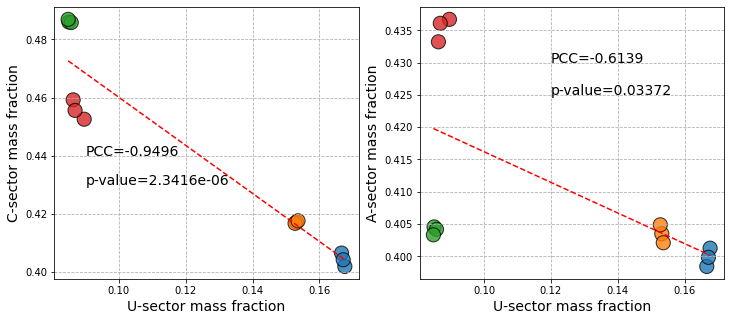

In [18]:
pH_colors = ['tab:red']*3+['tab:green']*3+['tab:orange']*3+['tab:blue']*3
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].scatter(ratio_table.iloc[3][1:], ratio_table.iloc[0][1:],edgecolor='black',linewidth=1, 
               s=200,alpha=0.8, color=pH_colors)
add_linear(axs[0], ratio_table.iloc[3][1:], ratio_table.iloc[0][1:])
axs[1].scatter(ratio_table.iloc[3][1:], ratio_table.iloc[2][1:],edgecolor='black',linewidth=1, 
               s=200,alpha=0.8, color=pH_colors)
add_linear(axs[1], ratio_table.iloc[3][1:], ratio_table.iloc[2][1:])
for ax in axs:
    ax.set_xlabel('U-sector mass fraction',fontsize=14)
    ax.grid(linestyle='--')
axs[0].set_ylabel('C-sector mass fraction',fontsize=14)
axs[1].set_ylabel('A-sector mass fraction',fontsize=14)

axs[0].text(0.09,0.44,s='PCC=-0.9496',fontsize=14)
axs[0].text(0.09,0.43,s='p-value=2.3416e-06',fontsize=14)
axs[1].text(0.12,0.43,s='PCC=-0.6139',fontsize=14)
axs[1].text(0.12,0.425,s='p-value=0.03372',fontsize=14)
# plt.savefig('../../../../EPS_LP/Figures/proteome_tradeoff.svg',format='svg',dpi=150)

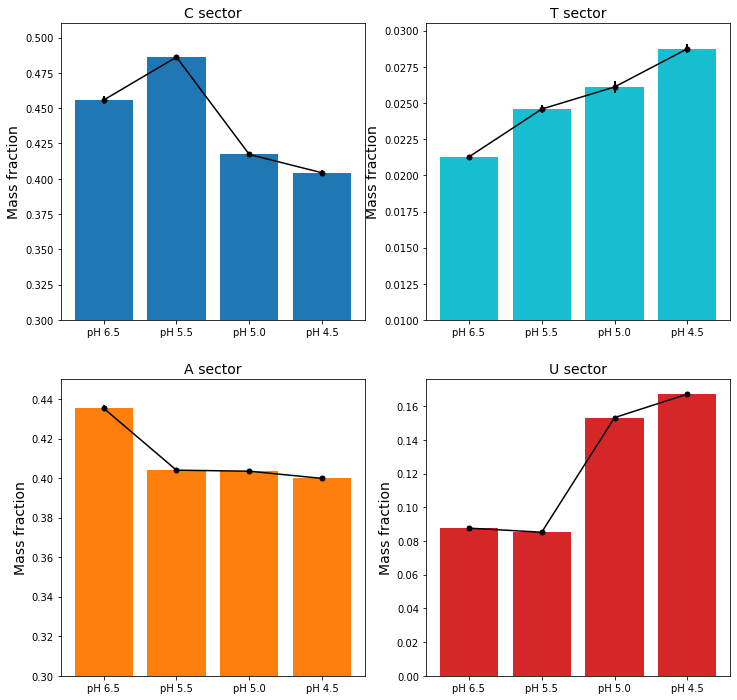

In [19]:
fig, axs = plt.subplots(2,2,figsize=(12,12))
colors = ['tab:blue','tab:cyan','tab:orange','tab:red']
conds = ['pH6.5','pH5.5','pH5','pH4.5']
for i in range(len(ratio_table.index)):
    values = list( ratio_table.iloc[i][1:])
    temp_sec = list(ratio_table['sector'])[i]
    avgs, stds= [],[]
    for j in range(len(conds)):
        avgs.append( np.mean([values[j*3],values[j*3+1],values[j*3+2] ]))
        stds.append( np.std([values[j*3],values[j*3+1],values[j*3+2] ]) )
    x,y = int(i/2), int(i%2)
    plot_conds = ['pH 6.5','pH 5.5','pH 5.0','pH 4.5']
    axs[x][y].bar(plot_conds, avgs, color =colors[i])
    axs[x][y].errorbar(plot_conds, avgs, marker='o',markersize=5, elinewidth=2, yerr=stds,color="black")
    axs[x][y].set_title(temp_sec+' sector',fontsize=14)
    axs[x][y].set_ylabel('Mass fraction', fontsize=14)
axs[0][0].set_ylim([0.3,0.51])
axs[0][1].set_ylim([0.01,0.0305])
axs[1][0].set_ylim([0.3,0.45])
# plt.savefig('../../../../EPS_LP/Figures/sector_vs_pH.svg',format='svg',dpi=150)

# Equation discovery for U/(A+C)

In [42]:
sec_expr_table

,sector,pH6.5-1,pH6.5-2,pH6.5-3,pH5.5-1,pH5.5-2,pH5.5-3,pH5-1,pH5-2,pH5-3,pH4.5-1,pH4.5-2,pH4.5-3
0,C,71.375217,71.007676,70.366571,72.086005,71.663209,72.366470,68.441485,68.785790,68.097180,64.812136,65.872762,65.342449
1,T,3.302442,3.315682,3.312254,3.628535,3.585963,3.712618,4.282620,4.223713,4.341526,4.698778,4.595434,4.647106
2,A,67.335147,68.519734,67.355088,60.011841,59.626008,59.950449,66.192857,66.821894,65.563820,64.701355,64.558362,64.629858
3,U,13.416857,14.061554,13.419528,12.612391,12.648523,12.607449,25.126556,25.206325,25.046787,27.029122,27.001094,27.015108


In [30]:
c_fracs = sec_expr_table.iloc[0][1:].values
a_fracs = sec_expr_table.iloc[2][1:].values
u_fracs = sec_expr_table.iloc[3][1:].values
up_ratios = u_fracs/(a_fracs+c_fracs)

u_avgs, u_stds=[],[]
for i in range(4):
    u_avgs.append(  np.mean([up_ratios[i*3],up_ratios[i*3+1],up_ratios[i*3+2] ]) )
    u_stds.append( np.std([up_ratios[i*3],up_ratios[i*3+1],up_ratios[i*3+2] ])  )

In [32]:
conds = [6.5,5.5,5.0,4.5]
def sigmoid_func(x, r1, k1, k2):
    r0=0.0983;
    return r0+r1/(1+np.exp(k1*(x-k2)))

popt, pcov = curve_fit( sigmoid_func, conds, u_avgs)
print(popt)

[ 0.10955478 44.60158979  5.03197226]


0.9993252553354687


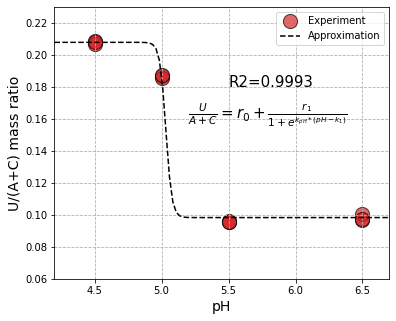

In [48]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter([6.5]*3+[5.5]*3+[5.0]*3+[4.5]*3, up_ratios, color='tab:red',
           alpha=0.7, edgecolor='black', s=200, label='Experiment')
temp_pHs = np.linspace(4.2, 6.7,num=100)
ax.plot(temp_pHs, [sigmoid_func(x, 0.1096, 44.6016, 5.0320) for x in temp_pHs],
        color='black',linestyle='--', label='Approximation')

r2 =  r2_score( [sigmoid_func(x, 0.1096, 44.6016, 5.0320) for x in conds],u_avgs )
print(r2)
ax.text(5.5,0.18,s='R2=0.9993',fontsize=15)
ax.text(5.2,0.16,s=r'$\frac{U}{A+C}=r_{0}+\frac{r_{1}}{1+e^{k_{pH}*(pH-k_{1})} }$',fontsize=15)

ax.set_ylim([0.06,0.23])
ax.set_xlim([4.2,6.7])
ax.grid(linestyle='--')
ax.legend()
ax.set_xlabel('pH',fontsize=14)
ax.set_ylabel('U/(A+C) mass ratio',fontsize=14)
# plt.savefig('../../../../EPS_LP/Figures/Ufrac_curvefit.svg',format='svg',dpi=150)